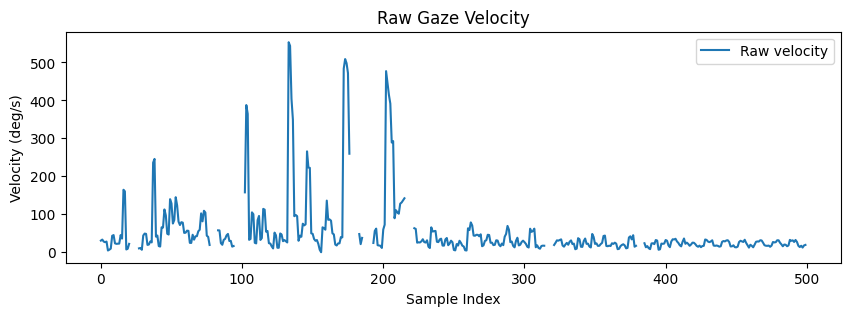

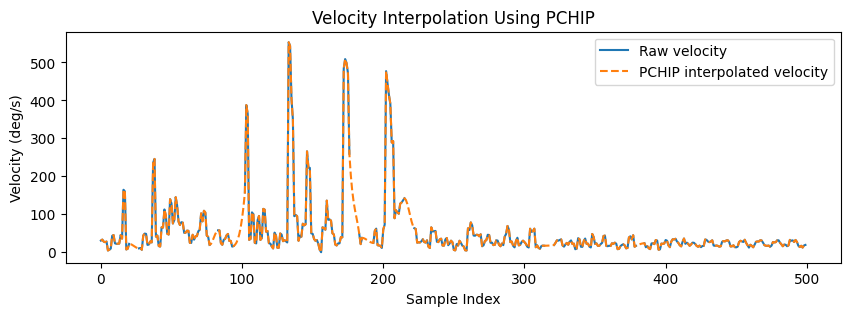

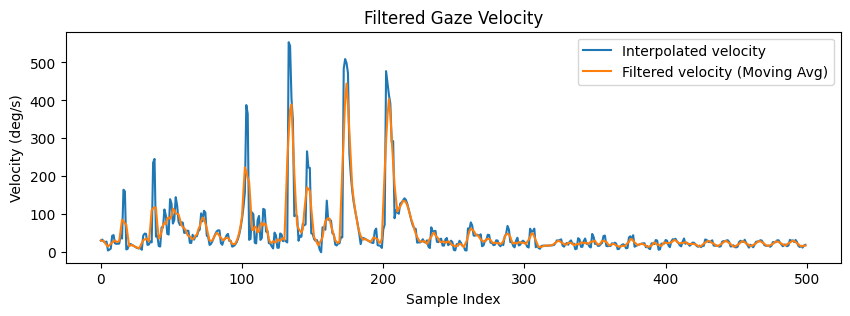

Chunk-wise analysis over 10 chunks:

Chunk 1: Fixations=3, AvgFixDur=140.0ms, AvgFixVel=20.62 deg/s, Saccades=5, AvgSacDur=112.0ms, AvgSacVel=67.06 deg/s
Chunk 2: Fixations=1, AvgFixDur=100.0ms, AvgFixVel=24.56 deg/s, Saccades=2, AvgSacDur=450.0ms, AvgSacVel=58.15 deg/s
Chunk 3: Fixations=1, AvgFixDur=100.0ms, AvgFixVel=26.66 deg/s, Saccades=2, AvgSacDur=450.0ms, AvgSacVel=121.75 deg/s
Chunk 4: Fixations=2, AvgFixDur=60.0ms, AvgFixVel=25.03 deg/s, Saccades=5, AvgSacDur=160.0ms, AvgSacVel=109.10 deg/s
Chunk 5: Fixations=2, AvgFixDur=170.0ms, AvgFixVel=26.64 deg/s, Saccades=2, AvgSacDur=330.0ms, AvgSacVel=135.22 deg/s
Chunk 6: Fixations=3, AvgFixDur=186.7ms, AvgFixVel=23.22 deg/s, Saccades=3, AvgSacDur=133.3ms, AvgSacVel=44.11 deg/s
Chunk 7: Fixations=3, AvgFixDur=286.7ms, AvgFixVel=22.35 deg/s, Saccades=2, AvgSacDur=70.0ms, AvgSacVel=39.47 deg/s
Chunk 8: Fixations=3, AvgFixDur=293.3ms, AvgFixVel=20.61 deg/s, Saccades=3, AvgSacDur=40.0ms, AvgSacVel=31.82 deg/s
Chunk 9: Fixations=3, AvgFi

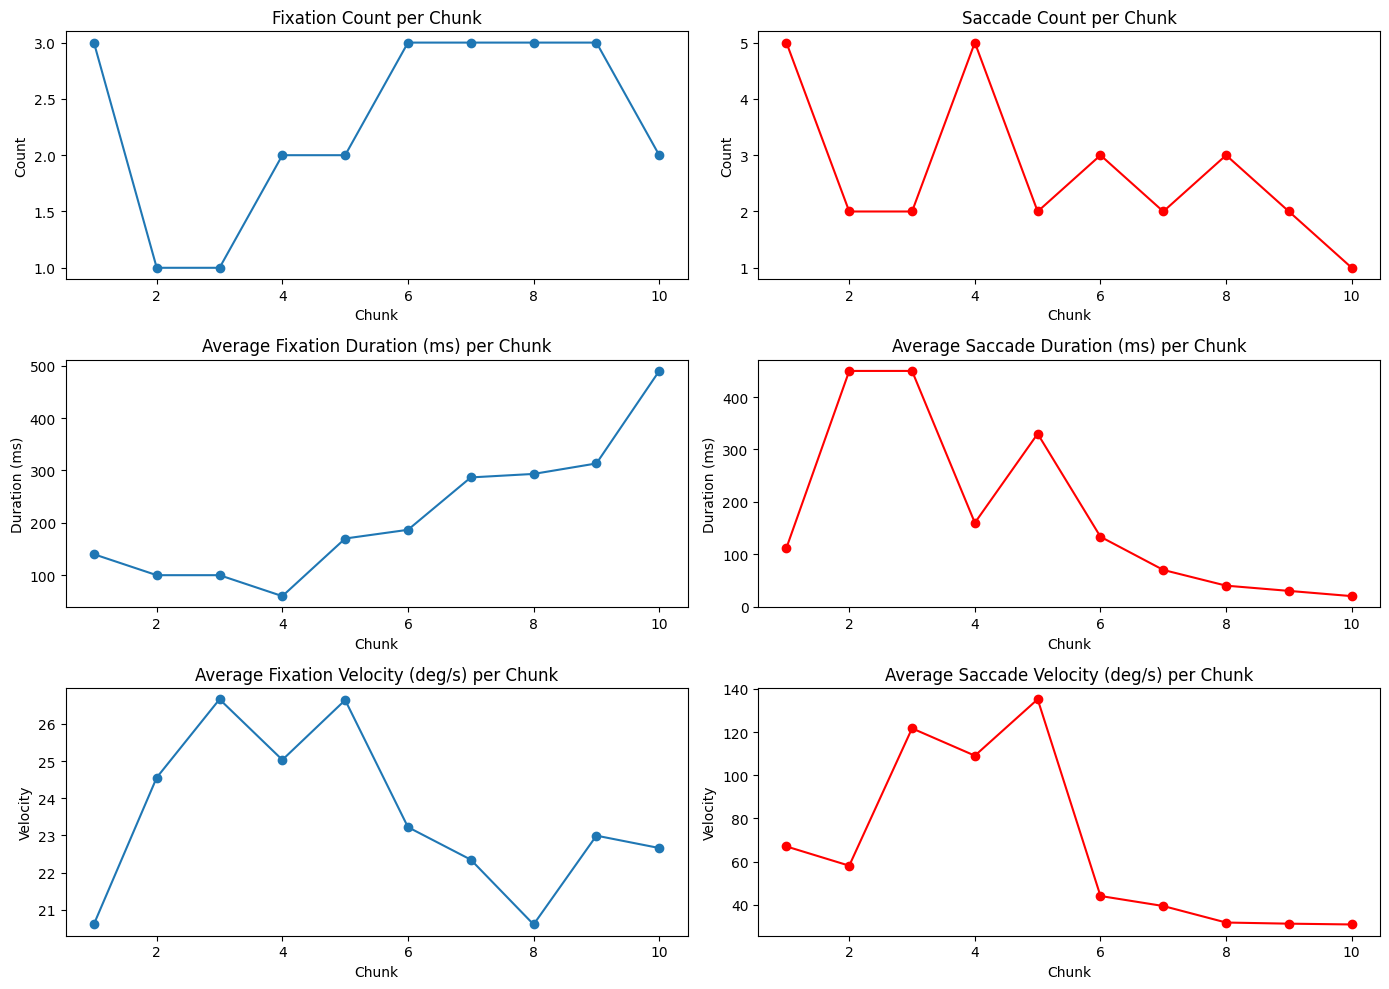

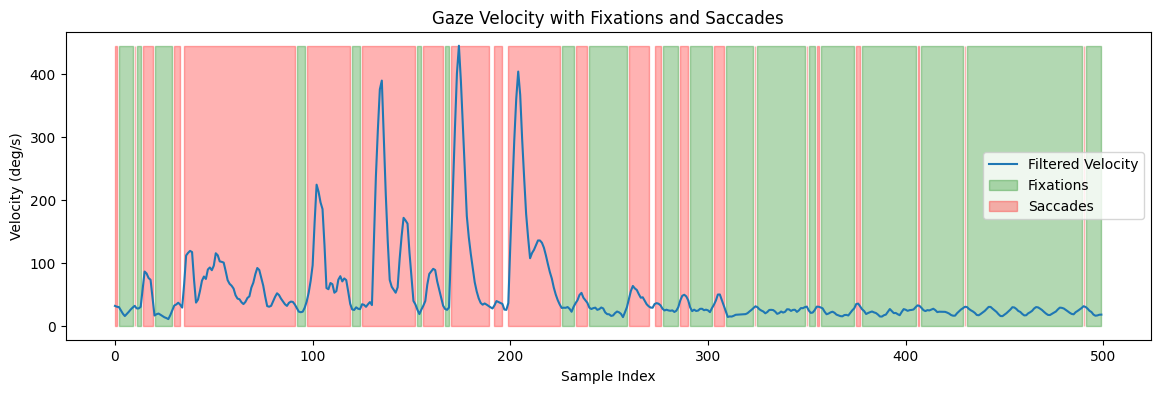

In [2]:
# Eye Tracking Parameter Extraction using IVT Filter with PCHIP Interpolation
#
# This notebook demonstrates a full working example of gaze velocity segmentation
# using a minimal IVT (velocity threshold) filter with PCHIP interpolation for missing
# data, smoothing, and basic statistics calculations across time windows.

# %%
import numpy as np
from scipy.interpolate import PchipInterpolator
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt

SPS = 50  # Samples per second (sampling rate)
DEFAULT_VELOCITY_THRESHOLD = 30  # degrees per second
MIN_FIXATION_DURATION_MS = 60
MIN_SACCADE_DURATION_MS = 20


def interpolate_velocity_with_pchip(velocity_data: np.ndarray) -> np.ndarray:
    """
    Interpolates missing data (NaNs) in velocity using shape-preserving PCHIP interpolation.

    Parameters:
        velocity_data (np.ndarray): 1D array of gaze velocity values with possible NaNs.

    Returns:
        np.ndarray: Velocity array with NaNs replaced by interpolated values.
    """
    valid_mask = ~np.isnan(velocity_data)
    valid_indices = np.where(valid_mask)[0]
    valid_values = velocity_data[valid_mask]

    if len(valid_indices) < 2:
        raise ValueError("Not enough valid data points for interpolation.")

    interpolator = PchipInterpolator(valid_indices, valid_values)
    interpolated = interpolator(np.arange(len(velocity_data)))

    # Clip negative values to zero to avoid negative velocities
    interpolated = np.clip(interpolated, a_min=0, a_max=None)

    return interpolated


def create_fixation_saccade_arrays(
    gaze_velocity: np.ndarray,
    velocity_threshold: float = DEFAULT_VELOCITY_THRESHOLD,
    min_fixation_duration_ms: int = MIN_FIXATION_DURATION_MS,
    min_saccade_duration_ms: int = MIN_SACCADE_DURATION_MS,
    sampling_rate_hz: int = SPS
) -> tuple[np.ndarray, np.ndarray]:
    """
    Classify each sample in gaze_velocity as fixation or saccade using an IVT filter.

    Parameters:
        gaze_velocity (np.ndarray): 1D array of gaze velocity values.
        velocity_threshold (float): Velocity threshold to distinguish fixations from saccades.
        min_fixation_duration_ms (int): Minimum fixation duration in ms.
        min_saccade_duration_ms (int): Minimum saccade duration in ms.
        sampling_rate_hz (int): Sampling rate of the data in Hz.

    Returns:
        fixation_array (np.ndarray): Binary array where 1 indicates fixation samples.
        saccade_array (np.ndarray): Binary array where 1 indicates saccade samples.
    """
    if gaze_velocity.ndim != 1:
        raise ValueError("gaze_velocity must be a 1D numpy array.")

    min_fixation_samples = int(min_fixation_duration_ms / (1000 / sampling_rate_hz))
    min_saccade_samples = int(min_saccade_duration_ms / (1000 / sampling_rate_hz))

    fixation_array = np.zeros(len(gaze_velocity), dtype=int)
    saccade_array = np.zeros(len(gaze_velocity), dtype=int)

    i = 0
    while i < len(gaze_velocity):
        if gaze_velocity[i] < velocity_threshold:
            fixation_start = i
            while i < len(gaze_velocity) and gaze_velocity[i] < velocity_threshold:
                i += 1
            fixation_end = i
            duration = fixation_end - fixation_start
            if duration >= min_fixation_samples:
                fixation_array[fixation_start:fixation_end] = 1
        else:
            saccade_start = i
            while i < len(gaze_velocity) and gaze_velocity[i] >= velocity_threshold:
                i += 1
            saccade_end = i
            duration = saccade_end - saccade_start
            if duration >= min_saccade_samples:
                saccade_array[saccade_start:saccade_end] = 1

    return fixation_array, saccade_array


def compute_statistics(
    fixation_array: np.ndarray,
    saccade_array: np.ndarray,
    gaze_velocity: np.ndarray,
    sampling_rate_hz: int = SPS
) -> tuple[int, float, float, int, float, float]:
    """
    Compute basic eye-tracking statistics from fixation and saccade arrays.

    Parameters:
        fixation_array (np.ndarray): Binary array indicating fixation samples.
        saccade_array (np.ndarray): Binary array indicating saccade samples.
        gaze_velocity (np.ndarray): Array of gaze velocity values.
        sampling_rate_hz (int): Sampling rate of the data (Hz).

    Returns:
        fixation_count (int): Number of detected fixations.
        avg_fixation_duration_ms (float): Average fixation duration in milliseconds.
        avg_fixation_velocity (float): Average velocity during fixations.
        saccade_count (int): Number of detected saccades.
        avg_saccade_duration_ms (float): Average saccade duration in milliseconds.
        avg_saccade_velocity (float): Average velocity during saccades.
    """
    if not (fixation_array.shape == saccade_array.shape == gaze_velocity.shape):
        raise ValueError("Input arrays must have the same shape.")

    fixation_duration_samples = fixation_array.sum()
    saccade_duration_samples = saccade_array.sum()

    # Count number of fixations and saccades (transitions from 0 to 1)
    fixation_count = np.count_nonzero(np.diff(np.concatenate(([0], fixation_array))) == 1)
    saccade_count = np.count_nonzero(np.diff(np.concatenate(([0], saccade_array))) == 1)

    avg_fixation_duration_ms = (
        (fixation_duration_samples / fixation_count) * (1000 / sampling_rate_hz)
        if fixation_count > 0 else 0.0
    )
    avg_saccade_duration_ms = (
        (saccade_duration_samples / saccade_count) * (1000 / sampling_rate_hz)
        if saccade_count > 0 else 0.0
    )

    fixation_velocities = gaze_velocity[fixation_array == 1]
    avg_fixation_velocity = fixation_velocities.mean() if fixation_velocities.size > 0 else 0.0

    saccade_velocities = gaze_velocity[saccade_array == 1]
    avg_saccade_velocity = saccade_velocities.mean() if saccade_velocities.size > 0 else 0.0

    return (
        fixation_count,
        avg_fixation_duration_ms,
        avg_fixation_velocity,
        saccade_count,
        avg_saccade_duration_ms,
        avg_saccade_velocity
    )


# %%
# Example: load your velocity data
base_velocity = np.load('/content/data_example.npy')  # Adjust path as needed

# Plot raw velocity data with NaNs
plt.figure(figsize=(10, 3))
plt.plot(base_velocity, label='Raw velocity')
plt.title("Raw Gaze Velocity")
plt.xlabel("Sample Index")
plt.ylabel("Velocity (deg/s)")
plt.legend()
plt.show()

# %%
# Interpolate NaNs with PCHIP
interpolated_velocity = interpolate_velocity_with_pchip(base_velocity)

plt.figure(figsize=(10, 3))
plt.plot(base_velocity, label='Raw velocity')
plt.plot(interpolated_velocity, '--', label='PCHIP interpolated velocity')
plt.title("Velocity Interpolation Using PCHIP")
plt.xlabel("Sample Index")
plt.ylabel("Velocity (deg/s)")
plt.legend()
plt.show()

# %%
# Smooth velocity with moving average filter (100 ms window = 5 samples)
filtered_velocity = uniform_filter1d(interpolated_velocity, size=5)

plt.figure(figsize=(10, 3))
plt.plot(interpolated_velocity, label='Interpolated velocity')
plt.plot(filtered_velocity, label='Filtered velocity (Moving Avg)')
plt.title("Filtered Gaze Velocity")
plt.xlabel("Sample Index")
plt.ylabel("Velocity (deg/s)")
plt.legend()
plt.show()

# %%
# Run IVT segmentation to detect fixations and saccades
fixation_array, saccade_array = create_fixation_saccade_arrays(filtered_velocity)

# %%
# Chunk-wise statistics calculation
chunk_size = 50  # samples
n_samples = len(base_velocity)
n_chunks = n_samples // chunk_size

fix_counts, avg_fix_durations, avg_fix_vel = [], [], []
sac_counts, avg_sac_durations, avg_sac_vel = [], [], []

print(f"Chunk-wise analysis over {n_chunks} chunks:\n")

for chunk_i in range(n_chunks):
    start = chunk_i * chunk_size
    end = start + chunk_size

    fix_chunk = fixation_array[start:end]
    sac_chunk = saccade_array[start:end]
    vel_chunk = filtered_velocity[start:end]

    stats = compute_statistics(fix_chunk, sac_chunk, vel_chunk)

    fix_counts.append(stats[0])
    avg_fix_durations.append(stats[1])
    avg_fix_vel.append(stats[2])
    sac_counts.append(stats[3])
    avg_sac_durations.append(stats[4])
    avg_sac_vel.append(stats[5])

    print(
        f"Chunk {chunk_i + 1}: Fixations={stats[0]}, AvgFixDur={stats[1]:.1f}ms, "
        f"AvgFixVel={stats[2]:.2f} deg/s, Saccades={stats[3]}, "
        f"AvgSacDur={stats[4]:.1f}ms, AvgSacVel={stats[5]:.2f} deg/s"
    )

# %%
# Plot chunk-wise results
chunks = np.arange(1, n_chunks + 1)

plt.figure(figsize=(14, 10))

plt.subplot(3, 2, 1)
plt.plot(chunks, fix_counts, 'o-')
plt.title("Fixation Count per Chunk")
plt.xlabel("Chunk")
plt.ylabel("Count")

plt.subplot(3, 2, 2)
plt.plot(chunks, sac_counts, 'o-', color='r')
plt.title("Saccade Count per Chunk")
plt.xlabel("Chunk")
plt.ylabel("Count")

plt.subplot(3, 2, 3)
plt.plot(chunks, avg_fix_durations, 'o-')
plt.title("Average Fixation Duration (ms) per Chunk")
plt.xlabel("Chunk")
plt.ylabel("Duration (ms)")

plt.subplot(3, 2, 4)
plt.plot(chunks, avg_sac_durations, 'o-', color='r')
plt.title("Average Saccade Duration (ms) per Chunk")
plt.xlabel("Chunk")
plt.ylabel("Duration (ms)")

plt.subplot(3, 2, 5)
plt.plot(chunks, avg_fix_vel, 'o-')
plt.title("Average Fixation Velocity (deg/s) per Chunk")
plt.xlabel("Chunk")
plt.ylabel("Velocity")

plt.subplot(3, 2, 6)
plt.plot(chunks, avg_sac_vel, 'o-', color='r')
plt.title("Average Saccade Velocity (deg/s) per Chunk")
plt.xlabel("Chunk")
plt.ylabel("Velocity")

plt.tight_layout()
plt.show()

# %%
# Final plot: velocity with fixation and saccade overlays
plt.figure(figsize=(14, 4))
plt.plot(filtered_velocity, label='Filtered Velocity')
plt.fill_between(np.arange(n_samples), 0, filtered_velocity.max(),
                 where=fixation_array == 1, color='green', alpha=0.3, label='Fixations')
plt.fill_between(np.arange(n_samples), 0, filtered_velocity.max(),
                 where=saccade_array == 1, color='red', alpha=0.3, label='Saccades')
plt.title("Gaze Velocity with Fixations and Saccades")
plt.xlabel("Sample Index")
plt.ylabel("Velocity (deg/s)")
plt.legend()
plt.show()